In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import time
from matplotlib import rcParams


In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # 定义网络层，使用 ModuleList 来存储
        # Define the network layer, using the ModuleList to store the
        self.layers = nn.ModuleList([nn.Linear(2, 20)] + [nn.Linear(20, 20) for _ in range(3)] + [nn.Linear(20, 1)])

        # 初始化隐藏层的权重，使用 Kaiming He 初始化
        # Initialize the weights of the hidden layer using Kaiming He Initialization
        for layer in self.layers[:-1]:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='tanh')
        
        # 初始化输出层的权重
        # Initialize output layer weights
        nn.init.kaiming_normal_(self.layers[-1].weight, nonlinearity='linear')

    def forward(self, x):
       
        # 依次通过隐藏层，使用 tanh 作为激活函数
        # Pass through the hidden layers sequentially, using tanh as the activation function
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        
        # 通过输出层
        # Through the output layer
        x = self.layers[-1](x)
        return x

In [13]:
# 定义自定义模块用于计算导数
# Define custom modules for calculating derivatives
class Dif_u(nn.Module):
    def __init__(self, fnn):
        super(Dif_u, self).__init__()
        
        # 传入的神经网络模型
        # Afferent neural network models
        self.fnn = fnn  
    
    def forward(self, xy):
      
        # 分离输入张量的 x 和 y 分量，并保留最后一个维度
        # Separate the x and y components of the input tensor and keep the last dimension
        x, y = (xy[..., i].unsqueeze(-1) for i in range(xy.shape[-1]))  
        
        # 启用梯度计算
        # Enable gradient calculation
        x.requires_grad_(True)
        y.requires_grad_(True)
        
        # 计算 u = fnn1(x, y) * x
        # Calculate u = fnn1(x, y) * x
        temp = self.fnn(torch.cat([x, y], dim=-1))
        u = temp * x
        #在这种情况下，我们采用 PINN 中的硬边界条件技术，即把 FNN 的输出作为中间输出，并与 x 相乘(u = FNN1(x,y) * x)
        #In this case, we apply the hard boundary condition technique in PINN; 
        #that is, we let the output of FNN as intermediate output and multiply it with x ( u = FNN1(x,y) * x ).

        # 计算一阶导数 u_x 和 u_y
        # Calculate the first order derivatives u_x and u_y
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]   
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        # 计算二阶导数 u_xx, u_xy 和 u_yy
        # Calculate the second order derivatives u_xx, u_xy and u_yy
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_xy = torch.autograd.grad(u_x, y, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
        
        return u_x, u_y, u_xx, u_xy, u_yy

In [14]:
class Dif_v(nn.Module):
    def __init__(self, fnn):
        super(Dif_v, self).__init__()
       
        # 传入的神经网络模型  
        # Afferent neural network models      
        self.fnn = fnn  
    
    def forward(self, xy):
        
        # 分离输入张量的 x 和 y 分量，并保留最后一个维度 
        # Separate the x and y components of the input tensor and keep the last dimension       
        x, y = (xy[..., i].unsqueeze(-1) for i in range(xy.shape[-1])) 

        # 启用梯度计算
        # Enable gradient calculation        
        x.requires_grad_(True)
        y.requires_grad_(True)        
        
        # 计算 v = fnn2(x, y)
        # Calculate v = fnn2(x, y)
        v = self.fnn(torch.cat([x, y], dim=-1))

        # 计算一阶导数 u_x 和 u_y
        # Calculate the first order derivatives u_x and u_y
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]  
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]

        # 计算二阶导数 u_xx, u_xy 和 u_yy
        # Calculate the second order derivatives u_xx, u_xy and u_yy
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_xy = torch.autograd.grad(v_x, y, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
        
        return v_x, v_y, v_xx, v_xy, v_yy

In [15]:
class PINN(nn.Module):
    def __init__(self, net1, net2, mu):
        super(PINN, self).__init__()
       
        # 材料参数
        # Material parameters
        self.mu = mu

        # 用于计算 u 的导数
        # Used to calculate the derivative of u
        self.Dif1 = Dif_u(net1)

        # 用于计算 v 的导数
        # Used to calculate the derivative of v
        self.Dif2 = Dif_v(net2)
       
    def forward(self, x_train):
        
        # 从 x_train 中提取 xy, xy_u, xy_b, xy_l, xy_r
        # Extract xy, xy_u, xy_b, xy_l, xy_r from x_train
        xy = x_train[0]
        xy_u = x_train[1]
        xy_b = x_train[2]
        xy_l = x_train[3]
        xy_r = x_train[4]
        
        # 获取 xy 处 u 和 v 的导数
        # Get the derivatives of u and v at xy
        U_x, U_y, U_xx, U_xy, U_yy = self.Dif1(xy)
        V_x, V_y, V_xx, V_xy, V_yy = self.Dif2(xy)

        # 获取 xy_u 处 u 和 v 的导数
        # Get the derivatives of u and v at xy_u       
        U_u_x, U_u_y, U_u_xx, U_u_xy, U_u_yy = self.Dif1(xy_u)
        V_u_x, V_u_y, V_u_xx, V_u_xy, V_u_yy = self.Dif2(xy_u)

        # 获取 xy_b 处 u 和 v 的导数
        # Get the derivatives of u and v at xy_b   
        U_b_x, U_b_y, U_b_xx, U_b_xy, U_b_yy = self.Dif1(xy_b)
        V_b_x, V_b_y, V_b_xx, V_b_xy, V_b_yy = self.Dif2(xy_b)

        # 获取 xy_l 处 u 和 v 的导数
        # Get the derivatives of u and v at xy_l  
        U_l_x, U_l_y, U_l_xx, U_l_xy, U_l_yy = self.Dif1(xy_l)
        V_l_x, V_l_y, V_l_xx, V_l_xy, V_l_yy = self.Dif2(xy_l)

        # 获取 xy_r 处 u 和 v 的导数
        # Get the derivatives of u and v at xy_r 
        U_r_x, U_r_y, U_r_xx, U_r_xy, U_r_yy = self.Dif1(xy_r)
        V_r_x, V_r_y, V_r_xx, V_r_xy, V_r_yy = self.Dif2(xy_r)

        # 定义材料常数
        # Define material constants
        la = self.mu / (1 + self.mu) / (1 - 2 * self.mu)
        nu = 1 / (1 + self.mu) / 2

        # 计算应力边界条件的残差(两边同时除以E，因此为应变形式的残差)
        # Calculate the residual of the stress boundary condition 
        # (both sides divided by E at the same time, hence the residual in strain form)
        s_u_x = nu * U_u_y + nu * V_u_x
        s_u_y = (2 * nu + la) * V_u_y + la * U_u_x
        s_b_x = nu * U_b_y + nu * V_b_x
        s_b_y = (2 * nu + la) * V_b_y + la * U_b_x
        s_l_y = nu * U_l_y + nu * V_l_x
        s_r_y = nu * U_r_y + nu * V_r_x
        s_l_x = (2 * nu + la) * U_l_x + la * V_l_y
        s_r_x = (2 * nu + la) * U_r_x + la * V_r_y

        #计算平衡方程的残差
        # Obtain the residuals from equilibrium equation
        Gex = (2 * nu + la) * U_xx + nu * U_yy + (nu + la) * V_xy
        Gey = (nu + la) * U_xy + (2 * nu + la) * V_yy + nu * V_xx     

        return Gex, Gey, s_u_x, s_u_y, s_b_x, s_b_y, s_l_x, s_l_y, s_r_x, s_r_y   
        

In [16]:
class Opt_lbfgsb:
    def __init__(self, pinn, x_train, y_train, dx, h, factr=10, pgtol=1e-10, m=50, maxls=20, maxiter=20000):  
        """
        =================================================================================
        初始化优化器。
        Initialize the optimizer.

        参数 Parameters:
        pinn: PINN模型实例 The instance of the PINN model.
        x_train: 训练输入数据 A list of tensors representing the input training data.
        y_train: 目标数据 A list of tensors representing the target data.
        dx: 样本间距 The spacing between sample points.
        h: 权重 The weight for the loss calculation.
        factr: 收敛因子 Convergence factor for the L-BFGS-B optimizer.
        pgtol: 梯度公差 Gradient tolerance for the L-BFGS-B optimizer.
        m: 存储的最多校正对数 The maximum number of variable metric corrections used.
        maxls: 线搜索步数上限 Maximum number of line search steps.
        maxiter: 最大迭代次数 Maximum number of iterations.
        =================================================================================
        """

        # 传入的神经网络模型  
        # Afferent neural network models     
        self.pinn = pinn

        self.x_train =  x_train # 训练数据 x Training data x
        self.y_train =  y_train  # 目标数据 y Target data y                         
        self.dx = dx  # 样本间距 sample spacing
        self.h = h    # 权重 weights  
        self.factr = factr  # 收敛因子 convergence factor
        self.pgtol = pgtol  # 梯度公差 gradient tolerance
        self.m = m  # 存储的最多校正对数 Maximum number of calibration pairs stored
        self.maxls = maxls  # 线搜索步数上限 Line search step limit
        self.maxiter = maxiter  # 最大迭代次数 Maximum number of iterations
        self.metrics = ['loss']  # 度量指标 metric

    def set_weights(self, flat_weights):        
        """
        =================================================================================
        设置网络权重。
        Set the network weights.

        参数 Parameters:
        flat_weights: 展平的权重数组 The flattened array of weights.
        =================================================================================
        """
        
        # 获取NN参数(权重和偏差)的形状
        # Getting the shape of NN parameters (weights and biases)
        shapes = [w.shape for w in self.pinn.parameters()]
        
        # 计算每个参数展平后的大小
        # Calculate the size of each parameter after flattening
        split_sizes = [np.prod(shape) for shape in shapes]
        
        # 计算参数在展平数组中的切片索引
        # Compute the slice index of the parameter in the spreading array
        split_ids = np.cumsum([0] + split_sizes)

        # 将一维扁平化权重向量分割并重塑为原始的参数张量
        # Splitting and reshaping a one-dimensional flattened weight vector into the original parameter tensor
        weights = [torch.tensor(flat_weights[from_id:to_id], dtype=torch.float32).reshape(shape)
                   for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes)]
        
        # 打印出权重形状和名称，以便调试
        # Print out shapes and parameter names for debugging
        #for i, (name, param) in enumerate(self.pinn.named_parameters()):
        #    print(f"Setting weight for {name}: expected shape {param.shape}, got shape {weights[i].shape}")
        
        # 创建权重字典
        # Create a dictionary of weights
        state_dict = {name: weights[i] for i, (name, _) in enumerate(self.pinn.named_parameters())}
        
        # 加载新的权重到模型中
        # Load new weights into the model
        self.pinn.load_state_dict(state_dict)

    def Loss_grad(self, x, y):        
        """
        =================================================================================
        计算损失和梯度。
        Compute loss and gradients.

        参数 Parameters:
        x: 输入数据 The input data.
        y: 目标输出 The target output.

        返回 Returns:
        loss: 损失值 The loss value.
        grads: 梯度列表 The list of gradients.
        l1: l1损失项 The l1 loss term.
        l2: l2损失项 The l2 loss term.
        =================================================================================
        """
        
        with torch.enable_grad():
            
            # 计算模型输出
            # Computational model output
            outputs = self.pinn(x)

            # 计算l1损失
            # Calculate l1 losses
            l1 = self.h * self.dx ** 2 * (torch.sum(torch.square(outputs[0])) +
                                            torch.sum(torch.square(outputs[1])))
            
            # 计算l2损失
            # Calculate l2 losses
            l2 = (self.dx * (torch.sum(torch.square(outputs[2]-y[0])) +
                                torch.sum(torch.square(outputs[3]-y[1]))) +
                    self.dx * (torch.sum(torch.square(outputs[4]-y[2])) +
                                torch.sum(torch.square(outputs[5]-y[3]))) +
                    self.dx * (torch.sum(torch.square(outputs[7]-y[5]))) +
                    self.dx * (torch.sum(torch.square(outputs[8]-y[6]))) +
                    self.dx * (torch.sum(torch.square(outputs[9]-y[7]))))

            # 总损失
            # total loss
            loss = l1 + l2 
        
        # 计算损失相对于参数的梯度
        # Calculate the gradient of the loss with respect to the parameter
        grads = torch.autograd.grad(loss, self.pinn.parameters(), create_graph=True, allow_unused=True)
        ### 部分参数并未参与求loss，因此需要设置allow_unused=True
        ### Some of the parameters are not involved in the loss, so you need to set allow_unused=True.

        return loss, grads, l1, l2


    def Loss(self, weights):
        """
        =================================================================================
        计算损失。
        Compute the loss.

        参数 Parameters:
        weights: 展平的权重数组 The flattened array of weights.

        返回 Returns:
        loss: 损失值 The loss value.
        grads: 梯度数组 The array of gradients.
        =================================================================================
        """
        
        # 设置新的权重
        # Set new weights
        self.set_weights(weights)

        # 计算损失和梯度
        # Calculate losses and gradients
        loss, grads, l1, l2 = self.Loss_grad(self.x_train, self.y_train)
        
        # 打印损失
        # Print Loss
        print('L1 =', l1.detach().numpy(), '   L2 =', l2.detach().numpy(), '   Loss =', loss.detach().numpy())
        
        # 转换loss为numpy数组
        # Convert losses to numpy arrays
        loss = loss.detach().numpy().astype('float64')

        # 展平并连接所有梯度
        # Flatten and connect all gradients
        grads = np.concatenate([g.detach().numpy().flatten() if g is not None else np.zeros_like(p.detach().numpy().flatten())
                                for g, p in zip(grads, self.pinn.parameters())]).astype('float64')

        return loss, grads

    def fit(self):
        """
        =================================================================================
        训练模型。
        Fit the model.

        返回 Returns:
        result: 优化结果 The result of the optimization.
        =================================================================================
        """ 
        
        # 获取初始权重
        # Get initial weights       
        initial_weights = torch.cat([w.flatten() for w in self.pinn.parameters()]).detach().numpy()
        
        # 使用L-BFGS-B优化器进行训练
        # Training with the L-BFGS-B optimizer
        result = scipy.optimize.fmin_l_bfgs_b(func=self.Loss, x0=initial_weights, 
                                              factr=self.factr, pgtol=self.pgtol, 
                                              m=self.m, maxls=self.maxls, 
                                              maxiter=self.maxiter)
        
        return result


In [17]:
# 设置字体为Times new Roman字体
# Set the font to the Times new Roman
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

# 定义坐标边界和保存路径
# Define coordinate boundaries and save paths
xmin, xmax = -0.01, 0.51
ymin, ymax = -0.075, 0.075
save_path = './CPU/'

def Vis(E, pinn, net1, net2, xy, T, L, it):
    """
    =================================================================================================================================
    
    可视化函数，绘制位移和应力的等值图并保存结果。
    Visualization function to plot displacement and stress contour plots and save the results.

    参数 Parameters:
    E (float): 杨氏模量 Young's modulus.
    pinn (torch.nn.Module): 已训练的物理信息神经网络 Trained Physics-Informed Neural Network (PINN).
    net1 (torch.nn.Module): 用于预测位移u的前馈神经网络 Feedforward Neural Network for predicting displacement u.
    net2 (torch.nn.Module): 用于预测位移v的前馈神经网络 Feedforward Neural Network for predicting displacement v.
    xy (Array of float32): 采样点坐标 Coordinates of the sampling points.
    T, L, it: 其他参数 Additional parameters.

    变量 Variables:
    u, v (Array of float32): 位移 Displacement.
    s11, s22, s12 (Array of float32): 应力 Stress components.

    =================================================================================================================================    
    """
    
    # 生成网格点坐标
    # Generate grid point coordinates
    xy = np.array([[i * 0.5 / 200, j * 0.5 / 200 - 0.05] for i in range(201) for j in range(41)], dtype=np.float32)
    xy_tensor = torch.tensor(xy).float()

    # 预测位移
    # Predicted displacement
    u = net1(xy_tensor).detach().numpy() * xy[:, 0, np.newaxis]
    v = net2(xy_tensor).detach().numpy() - net2(torch.tensor([[0., 0.]], dtype=torch.float32)).detach().numpy()

    # 使用传入的模型预测应力
    # Predicting stresses using the incoming model
    temp = pinn([xy_tensor for _ in range(5)])
    s11, s22, s12 = (temp[8].detach().numpy() * E, temp[3].detach().numpy() * E, temp[2].detach().numpy() * E)
    
    # 创建图像并绘制等值图
    # Create images and draw contour plots
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
    fig.subplots_adjust(hspace=0.3, wspace=0.05)

    # 等值图函数
    # Isogram function
    def plot_contour(ax, data, title, vmin, vmax):
        cf = ax.scatter(xy[:, 0], xy[:, 1], s=5, c=data, cmap='Spectral', vmin=vmin, vmax=vmax)
        ax.axis('equal')
        plt.colorbar(cf, ax=ax)
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        ax.set_title(title)
        ax.set_xlabel('x (m)')

    plot_contour(ax[0, 0], u, 'u', -0.0228, 0.0228)
    plot_contour(ax[0, 1], v, 'v', -0.1138, 0)
    plot_contour(ax[1, 0], s11, r'$\sigma_{x}$', -50, 50)
    plot_contour(ax[1, 1], s22, r'$\sigma_{y}$', -2, 2)
    plot_contour(ax[2, 0], s12, r'$\tau_{xy}$', -2, 2)

    # 隐藏最后一个子图的轴线
    # Hide the axes of the last subplot
    ax[2, 1].axis('off')  
    
    # 保存图像和数据
    # Save images and data
    fig.savefig(save_path + "LLL.png", dpi=600)
    scipy.io.savemat(save_path + 'out.mat', {'xy': xy, 'u': np.hstack([u, v]), 's11': s11, 's22': s22, 's12': s12, 'T': T, 'L': L, 'it': it})


In [18]:
def Input():
    """
    =================================================================================
    定义输入函数，包括采样点、材料属性和边界条件
    Define input functions, including sampling points, material properties, and boundary conditions

    Returns:
    ns (int): 总采样点数量 Total number of sampling points
    ns_u (int): 上下边界采样点数量 Number of sampling points at upper and lower boundaries
    ns_l (int): 左右边界采样点数量 Number of sampling points at the left and right boundaries
    x_train (list of torch.Tensor): 用于训练的输入坐标列表 List of input coordinates for training
    y_train (list of torch.Tensor): 用于训练的边界条件列表 用于训练的边界条件列表
    E (float): 杨氏模量 Young's modulus
    mu (float): 泊松比 Poisson's ratio
    dx (float): 采样点间隔 Sampling point interval
    h (float): 采样点坐标的缩放因子 Scaling factor for sampling point coordinates
    =================================================================================
    """
    print('-------------------------------------------------\n')
    print('                 Input Info.\n')
    print('-------------------------------------------------\n')
    
    # 采样点数量
    # number of sample points
    ns = 2121   # 总采样点数量 Total number of sampling points
    ns_u = 101  # 上下边界采样点数量 Number of sampling points at upper and lower boundaries
    ns_l = 21  # 左右边界采样点数量 Number of sampling points at the left and right boundaries

    # sample points' interval
    dx = 0.005   # 采样点间隔 Sampling point interval
    h = 100*dx   # 采样点坐标的缩放因子 Scaling factor for sampling point coordinates

    print(f"{ns} sample points")
    print(f"{ns_u} sample points on the top boundary; {ns_u} sample points on the bottom boundary;")
    print(f"{ns_l} sample points on the left boundary; {ns_l} sample points on the right boundary.")

    # 初始化样本点坐标
    # initialize sample points' coordinates    
    xy = np.zeros((ns, 2)).astype(np.float32)
    for i in range(0, ns_u):
        for j in range(0, ns_l):
            xy[i*ns_l+j, 0] = i * dx
            xy[i*ns_l+j, 1] = j * dx - 0.1
    xy_u = np.hstack([np.linspace(0, 0.5, ns_u).reshape(ns_u, 1).astype(np.float32), \
                        0.05 * np.ones((ns_u, 1)).astype(np.float32)])
    xy_b = np.hstack([np.linspace(0, 0.5, ns_u).reshape(ns_u, 1).astype(np.float32), \
                        -0.05 * np.ones((ns_u, 1)).astype(np.float32)])
    xy_l = np.hstack([np.zeros((ns_l, 1)).astype(np.float32), \
                        np.linspace(-0.05, 0.05, ns_l).reshape(ns_l, 1).astype(np.float32)])
    xy_r = np.hstack([0.5 * np.ones((ns_l, 1)).astype(np.float32), \
                        np.linspace(-0.05, 0.05, ns_l).reshape(ns_l, 1).astype(np.float32)])

    # 创建 PINN 输入列表
    # create PINN input list
    x_train = [torch.tensor(xy, dtype=torch.float32), # requires_grad=True
                torch.tensor(xy_u, dtype=torch.float32),
                torch.tensor(xy_b, dtype=torch.float32),
                torch.tensor(xy_l, dtype=torch.float32),
                torch.tensor(xy_r, dtype=torch.float32)]

    # 材料属性
    # material properties
    E = 1000.
    mu = 0.3
    print('The Young''s module is', E, '; The Poisson''s ratio is', mu, '.\n')
    print('-------------------------------------------------\n')

    #边界条件
    # boundary conditions
    """
        ||> ------------------------------------------------------
        ||>|                                                     |→→→→
        ||>|                                                     |→→→        
        ||>|                                                     |→→
        ||>|                                                     |→
        ||>|                                                    ←|
        ||>|                                                   ←←|
        ||>|                                                  ←←←|        
        ||>|                                                 ←←←←|
        ||> ------------------------------------------------------
    """

    s_u_x = np.zeros((ns_u, 1)).astype(np.float32)  #上边界x方向
    s_u_y = np.zeros((ns_u, 1)).astype(np.float32)  #上边界y方向
    s_b_x = np.zeros((ns_u, 1)).astype(np.float32)  #下边界x方向
    s_b_y = np.zeros((ns_u, 1)).astype(np.float32)  #下边界y方向
    s_l_x = np.zeros((ns_l, 1)).astype(np.float32)  #左边界x方向
    s_l_y = np.zeros((ns_l, 1)).astype(np.float32)  #左边界y方向
    s_r_x = xy_r[:, 1, np.newaxis] * 1000  #右边界x方向
    s_r_y = np.zeros((ns_l, 1)).astype(np.float32)  #右边界y方向

    # 创建 PINN 边界条件列表
    # create PINN boundary condition list
    y_train = [torch.tensor(s_u_x / E, dtype=torch.float32),
                torch.tensor(s_u_y / E, dtype=torch.float32),
                torch.tensor(s_b_x / E, dtype=torch.float32),
                torch.tensor(s_b_y / E, dtype=torch.float32),
                torch.tensor(s_l_x / E, dtype=torch.float32),
                torch.tensor(s_l_y / E, dtype=torch.float32),
                torch.tensor(s_r_x / E, dtype=torch.float32),
                torch.tensor(s_r_y / E, dtype=torch.float32)]

    return ns, ns_u, ns_l, x_train, y_train, E, mu, dx, h


In [19]:
# 实例化位移网络和物理信息神经网络
# Instantiating Displacement Networks and PINN
net_u = Net()
net_v = Net()
pinn = PINN(net_u, net_v, mu=0.3)

# 生成采样点、边界条件和材料属性
# Generate sample points, boundary conditions and material properties
ns, ns_u, ns_l, x_train, y_train, E, mu, dx, h = Input()

# 使用L-BFGS-B优化器进行训练 
# Training with the L-BFGS-B optimizer     
l_bfgs_b = Opt_lbfgsb(pinn, x_train, y_train, dx, h)
time_start = time.time()
result = l_bfgs_b.fit()  # 开始训练 Start training
time_end = time.time()
T = time_end-time_start  # 计算训练时间 Calculating training time
L = result[1]  # 最终损失值 Final loss value
it = result[2]['funcalls']  # 迭代次数 Number of iterations
print('-------------------------------------------------\n')
print('Time cost is', T, 's')  # 输出训练时间 Output training time
print('Final loss is', L, '')  # 输出最终损失值 Output final loss value
print('Training converges by', it, 'iterations\n')  # 输出收敛迭代次数 Output the number of convergent iterations
print('-------------------------------------------------\n')

-------------------------------------------------

                 Input Info.

-------------------------------------------------

2121 sample points
101 sample points on the top boundary; 101 sample points on the bottom boundary;
21 sample points on the left boundary; 21 sample points on the right boundary.
The Youngs module is 1000.0 ; The Poissons ratio is 0.3 .

-------------------------------------------------

L1 = 2.7155418    L2 = 0.9023481    Loss = 3.61789
L1 = 0.9440138    L2 = 9.647681    Loss = 10.591695
L1 = 2.0165122    L2 = 3.1761448    Loss = 5.192657
L1 = 0.7511496    L2 = 0.49511993    Loss = 1.2462695
L1 = 0.5838783    L2 = 0.3905671    Loss = 0.97444534
L1 = 0.3407333    L2 = 0.3424033    Loss = 0.6831366
L1 = 0.21699165    L2 = 0.30763865    Loss = 0.5246303
L1 = 0.1276197    L2 = 0.20341937    Loss = 0.33103907
L1 = 0.06566972    L2 = 0.10364692    Loss = 0.16931665
L1 = 0.051445104    L2 = 0.06370619    Loss = 0.11515129
L1 = 0.034111843    L2 = 0.023533866    

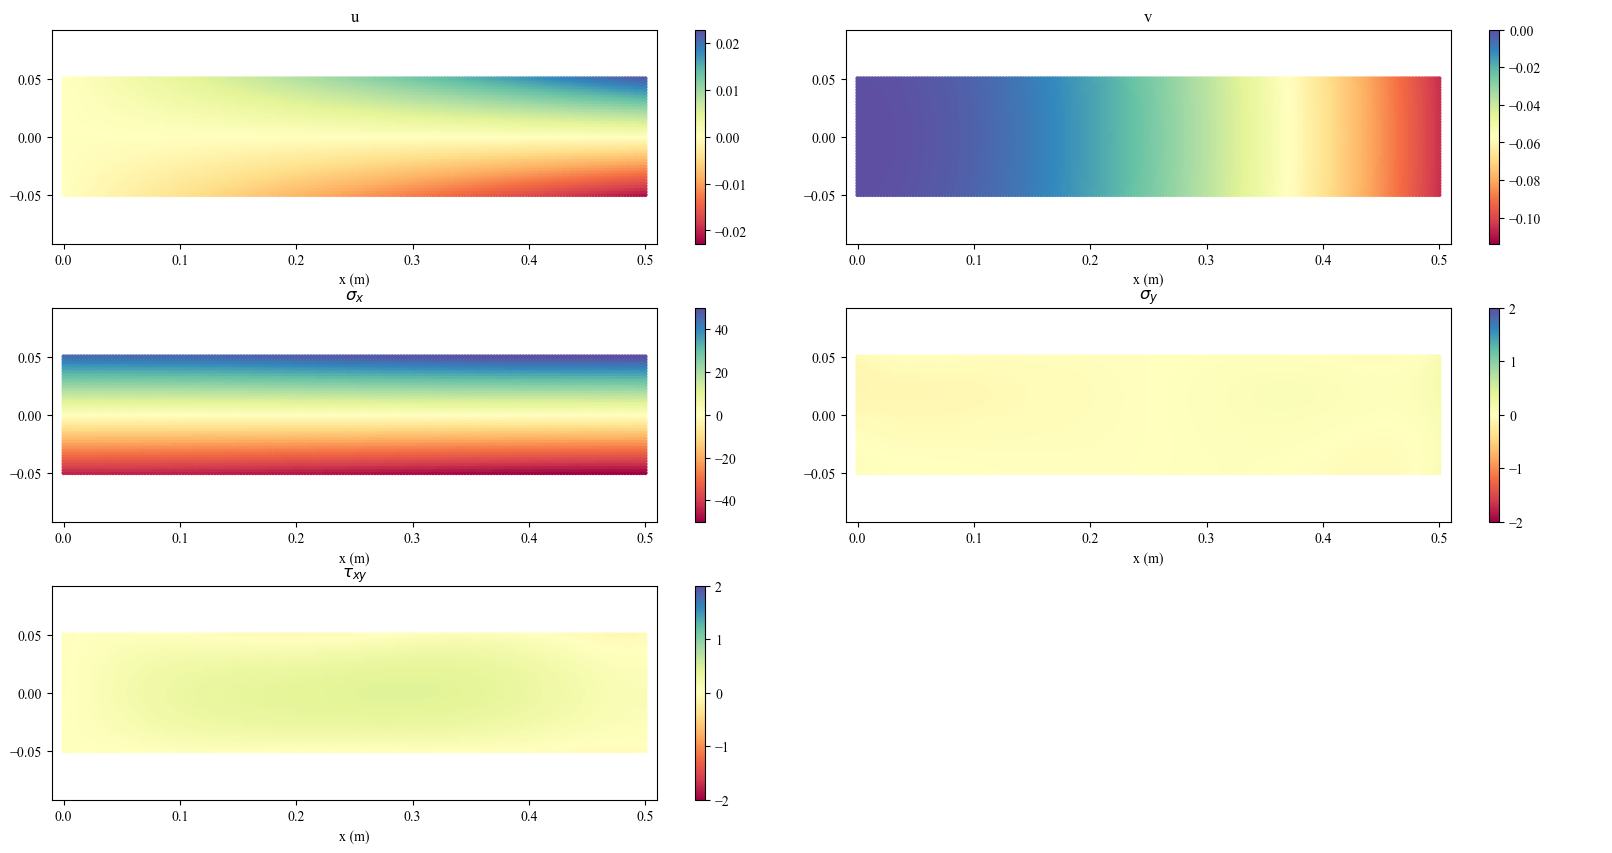

In [20]:
"""

        Visualize the results
    
"""

Vis(E, pinn, net_u, net_v, x_train[0], T, L, it)